In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from cs231n.data_utils import load_CIFAR10

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

try:
    del X_train, y_tarin
    del X_test, y_test
    print("Clear previously loaded data.")
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test data shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test data shape:  (10000,)


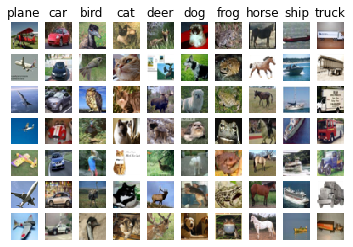

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y) # 储存所有下标
    idxs = np.random.choice(idxs, samples_per_class, replace=False) # 返回随机7个不重复的下标
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1   # subplot的下标从1开始
        plt.subplot(samples_per_class, num_classes, plt_idx)    # 三个参数：行数，列数，该子图的位置
        plt.imshow(X_train[idx].astype('uint8')) # RGB 0-255 用八位整数储存
        plt.axis('off') 
        if i == 0:
            plt.title(cls)  
plt.show() 

In [4]:
num_training = 5000
mask = list(range(num_training)) # 创建0-4999的下标列表
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

X_train = np.reshape(X_train, (X_train.shape[0], -1)) # 一共两个维度，第一维度5000，第二维度自动计算 32*32*3
X_test = np.reshape(X_test,(X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [5]:
from cs231n.classifiers import KNearestNeighbor
classifier = KNearestNeighbor()
classifier.train(X_train,y_train)

In [6]:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


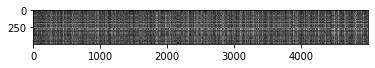

In [8]:
plt.imshow(dists, interpolation='none')
plt.show()

In [9]:
y_test_pred = classifier.predict_labels(dists,k=1)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct,num_test,accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [10]:
y_test_pred = classifier.predict_labels(dists,k=5)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct,num_test,accuracy))

Got 139 / 500 correct => accuracy: 0.278000


In [11]:
dists_one = classifier.compute_distances_one_loop(X_test)

difference = np.linalg.norm(dists - dists_one, ord = 'fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [12]:
dists_two = classifier.compute_distances_no_loops(X_test)

difference = np.linalg.norm(dists - dists_two, ord = 'fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [13]:
def time_function(f, *args):
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops,X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop,X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops,X_test)
print('No loop version took %f seconds' % no_loop_time)

Two loop version took 23.691077 seconds
One loop version took 28.670827 seconds
No loop version took 0.373787 seconds


In [14]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

x_train_folds = []
y_train_folds = []

x_train_folds = np.array_split(X_train,num_folds);
y_train_folds = np.array_split(y_train,num_folds);

k_to_accuracies = {}

for k in k_choices:
    
    accuracies = []
    
    for i in range(num_folds):
        x_train_fold = np.concatenate(x_train_folds[:i] + x_train_folds[i+1:])
        y_train_fold = np.concatenate(y_train_folds[:i] + y_train_folds[i+1:])
    
        classifier = KNearestNeighbor()
        classifier.train(x_train_fold,y_train_fold)
        
        y_test_pred = classifier.predict(x_train_folds[i], k = k, num_loops= 0)
        num_correct = np.sum(y_test_pred == y_train_folds[i])
        
        accuracy = float(num_correct) / x_train_folds[i].shape[0]
        accuracies.append(accuracy)
        
        print("Got %d / %d correct => accuracy: %f" % (num_correct, num_test, accuracy))
    k_to_accuracies[k] = accuracies;

for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f ' % (k,accuracy))

Got 263 / 500 correct => accuracy: 0.263000
Got 257 / 500 correct => accuracy: 0.257000
Got 264 / 500 correct => accuracy: 0.264000
Got 278 / 500 correct => accuracy: 0.278000
Got 266 / 500 correct => accuracy: 0.266000
Got 239 / 500 correct => accuracy: 0.239000
Got 249 / 500 correct => accuracy: 0.249000
Got 240 / 500 correct => accuracy: 0.240000
Got 266 / 500 correct => accuracy: 0.266000
Got 254 / 500 correct => accuracy: 0.254000
Got 248 / 500 correct => accuracy: 0.248000
Got 266 / 500 correct => accuracy: 0.266000
Got 280 / 500 correct => accuracy: 0.280000
Got 292 / 500 correct => accuracy: 0.292000
Got 280 / 500 correct => accuracy: 0.280000
Got 262 / 500 correct => accuracy: 0.262000
Got 282 / 500 correct => accuracy: 0.282000
Got 273 / 500 correct => accuracy: 0.273000
Got 290 / 500 correct => accuracy: 0.290000
Got 273 / 500 correct => accuracy: 0.273000
Got 265 / 500 correct => accuracy: 0.265000
Got 296 / 500 correct => accuracy: 0.296000
Got 276 / 500 correct => accurac

[0.2656 0.2496 0.2732 0.276  0.2802 0.2794 0.275  0.279  0.2744 0.2616]


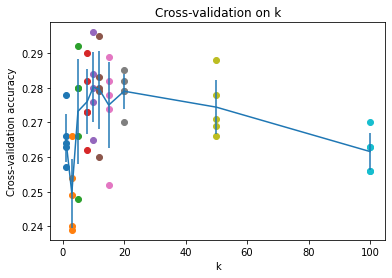

In [15]:
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies),accuracies)
accuracies_mean = np.array([np.mean(v) for k, v in sorted(k_to_accuracies.items())])
print(accuracies_mean)
accuracies_std = np.array([np.std(v) for k, v in sorted(k_to_accuracies.items())])

plt.errorbar(k_choices, accuracies_mean, accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()


In [17]:
best_k = k_choices[accuracies_mean.argmax()]

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k = best_k)

num_correct = np.sum(y_test_pred == y_test)
 
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000
